## Data exploration 

### Check data caravcteristics ..

In [2]:
import os
import pydicom
from pathlib import Path
from collections import Counter
from tqdm import tqdm


image_dir = Path("/home/tibia/Projet_Hemorragie/MBH_label_case")


all_files = list(image_dir.glob("*"))
print(f"Nombre total de fichiers : {len(all_files)}")
extensions = [f.suffix.lower() for f in all_files]

ext_counter = Counter(extensions)
print("Répartition des extensions de fichiers :")
for ext, count in ext_counter.items():
    print(f"{ext or '[sans extension]'} : {count}")



Nombre total de fichiers : 1981
Répartition des extensions de fichiers :
.gz : 1980
.csv : 1


In [4]:
import pandas as pd
from pathlib import Path



csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")

nii_dir = Path("/home/tibia/Projet_Hemorragie/MBH_label_case")

# Load CSV file
df = pd.read_csv(csv_path)

def check_files_exist(dataframe, base_path):
    missing = []
  
    for patient_id_study_id in dataframe['patientID_studyID']:
  
        expected_filename = f"{patient_id_study_id}.nii.gz"
        full_path = base_path / expected_filename
        if not full_path.exists():
            missing.append(expected_filename)
    return missing


missing_nii_files = check_files_exist(df, nii_dir)


print(f"Total IDs uniques dans le CSV : {len(df['patientID_studyID'].unique())}")
print(f"Fichiers .nii.gz manquants dans le répertoire : {len(missing_nii_files)}")
if missing_nii_files:
    print("Exemples des fichiers .nii.gz manquants :", missing_nii_files[:5])
else:
    print("Tous les fichiers .nii.gz correspondant aux IDs du CSV sont présents.")

Total IDs uniques dans le CSV : 577
Fichiers .nii.gz manquants dans le répertoire : 0
Tous les fichiers .nii.gz correspondant aux IDs du CSV sont présents.


In [6]:
import pandas as pd
import nibabel as nib
from pathlib import Path
import random

# Paths
csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
nii_dir = Path("/home/tibia/Projet_Hemorragie/MBH_label_case")

# Load CSV file
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at {csv_path}")
    exit()

# Get a list of all unique patient IDs from the CSV
patient_ids = df['patientID_studyID'].unique()

if not patient_ids.size:
    print("Error: No patient IDs found in the CSV file.")
    exit()

# Select a random patient ID
random_patient_id = random.choice(patient_ids)
image_filename = f"{random_patient_id}.nii.gz"
image_path = nii_dir / image_filename

print(f"Attempting to load random image: {image_path}")

# Load the NIfTI image and display its header (metadata)
try:
    img = nib.load(image_path)
    print("\n--- NIfTI Image Metadata (Header) ---")
    print(img.header)

    print(f"\nImage Shape (Dimensions): {img.shape}")
    print(f"Voxel Sizes (Resolutions): {img.header.get_zooms()}")
    print(f"Data Type: {img.header.get_data_dtype()}")
    print(f"Affine Matrix (Image to World Transform):\n{img.affine}")

    # --- Add the corresponding labels from the CSV ---
    print("\n--- Corresponding Labels from CSV ---")
    # Find the row in the DataFrame that matches the random_patient_id
    # .iloc[0] is used to get the first (and should be only) matching row
    # .drop('patientID_studyID') removes the ID column itself from the labels
    labels = df[df['patientID_studyID'] == random_patient_id].iloc[0].drop('patientID_studyID')

    # Display the labels
    print(labels.to_string()) # .to_string() for better multi-line printing of Series

except FileNotFoundError:
    print(f"Error: The image file {image_path} was not found. "
          "Please ensure the file exists at the specified path.")
except Exception as e:
    print(f"An error occurred while loading or processing the NIfTI image: {e}")

Attempting to load random image: /home/tibia/Projet_Hemorragie/MBH_label_case/ID_39ec8229_ID_97563b6363.nii.gz

--- NIfTI Image Metadata (Header) ---
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  29   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.429688 0.429688 5.517    0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      

###  hemorrahge repartition  

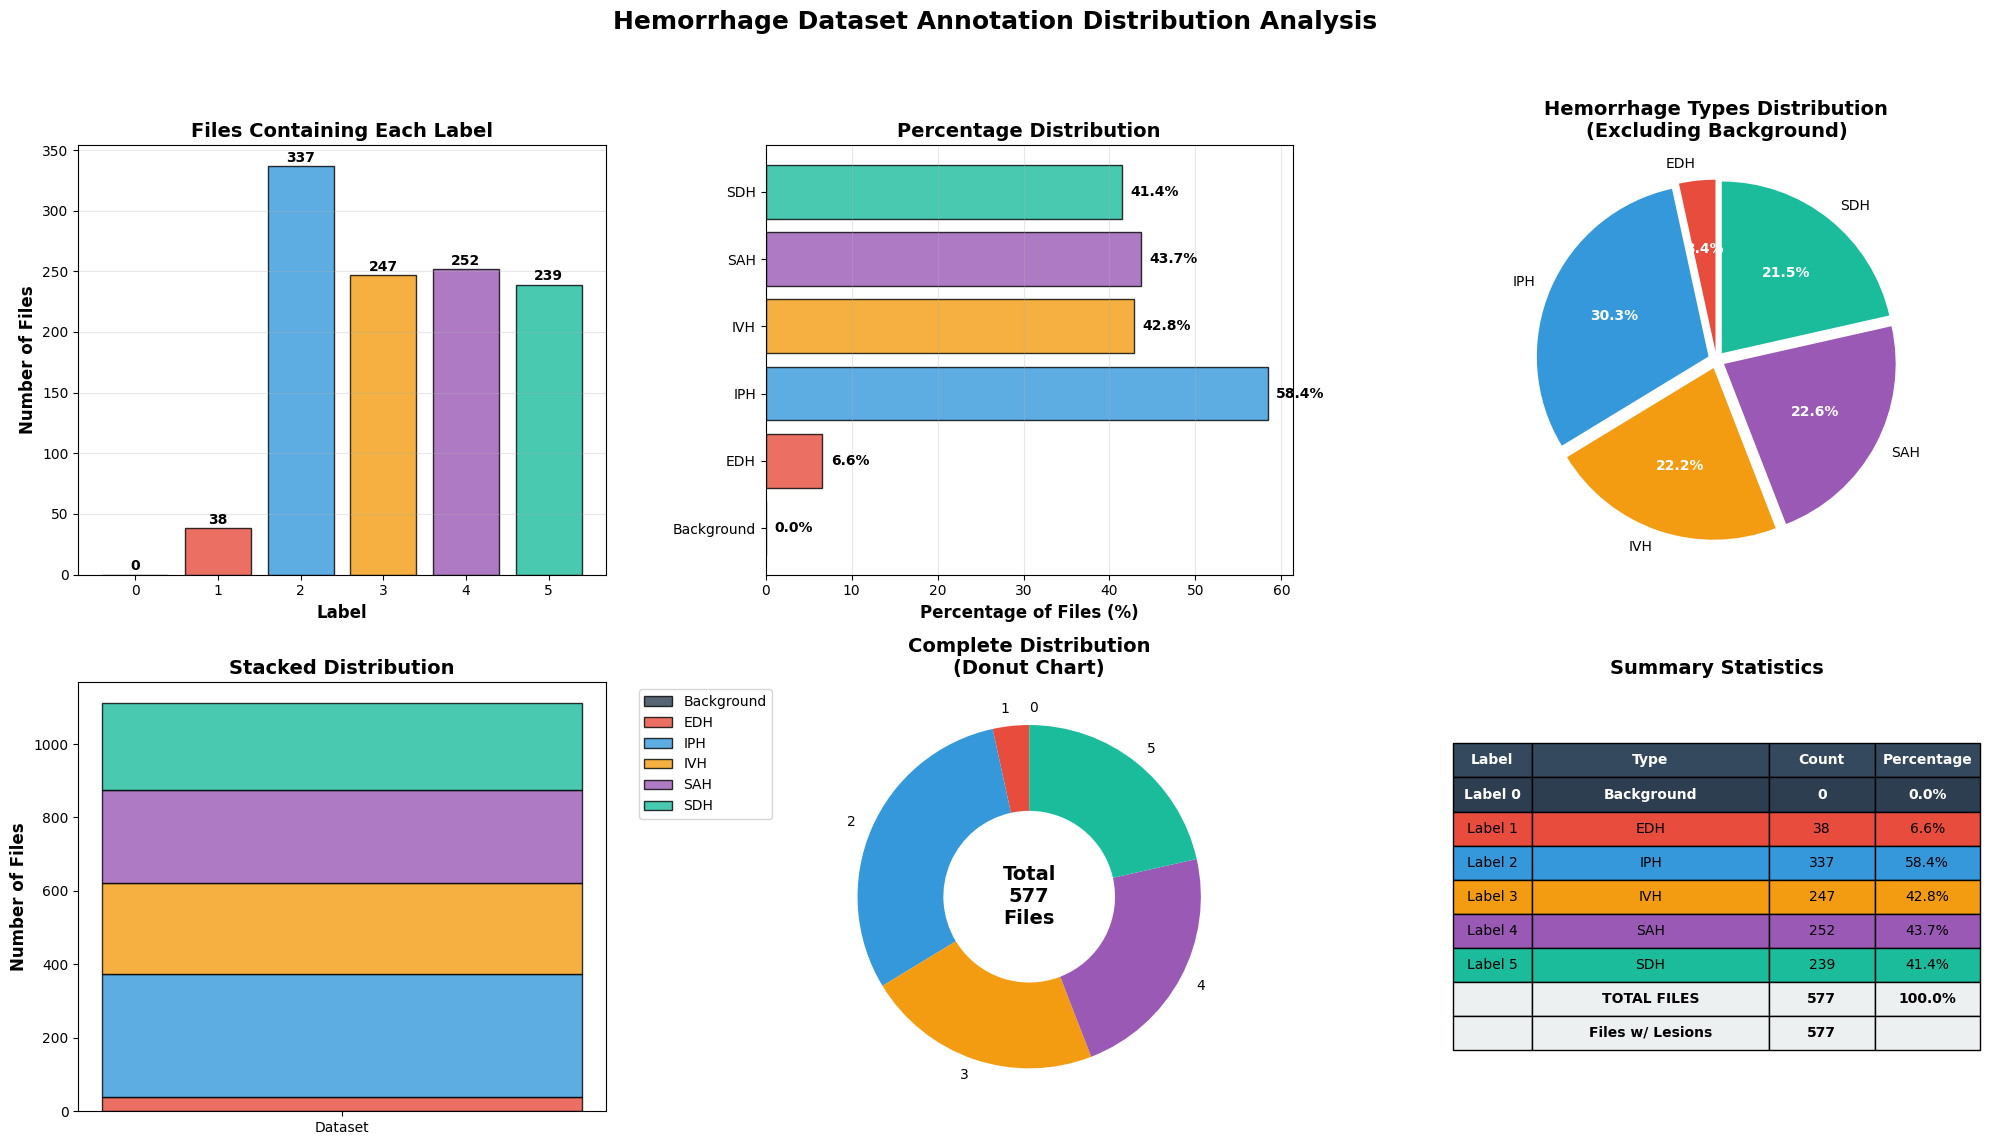


SUMMARY STATISTICS
Total files: 577
Files with background (Label 0): 0 (0.0%)
Files with hemorrhage types:
  Label 1: 38 files (6.6%)
  Label 2: 337 files (58.4%)
  Label 3: 247 files (42.8%)
  Label 4: 252 files (43.7%)
  Label 5: 239 files (41.4%)

Files with at least one hemorrhage (any=1): 577


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
df = pd.read_csv(csv_path)

def visualize_label_distribution(label_file_counts, total_files):
    fig = plt.figure(figsize=(20, 12))
    
    labels = list(range(6))
    counts = [label_file_counts[i] for i in labels]
    label_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C']
    
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax1.set_title('Files Containing Each Label', fontsize=14, fontweight='bold')
    ax1.set_xticks(labels)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    ax2 = plt.subplot(2, 3, 2)
    percentages = [(count/total_files)*100 for count in counts]
    bars2 = ax2.barh(label_names, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Percentage of Files (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    for i, (bar, pct) in enumerate(zip(bars2, percentages)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    ax3 = plt.subplot(2, 3, 3)
    hemorrhage_counts = counts[1:]
    hemorrhage_labels = label_names[1:]
    hemorrhage_colors = colors[1:]
    
    wedges, texts, autotexts = ax3.pie(hemorrhage_counts, labels=hemorrhage_labels, 
                                       colors=hemorrhage_colors, autopct='%1.1f%%',
                                       startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax3.set_title('Hemorrhage Types Distribution\n(Excluding Background)', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax4 = plt.subplot(2, 3, 4)
    background_count = counts[0]
    lesion_counts = counts[1:]
    
    bottom = 0
    bar_width = 0.6
    
    ax4.bar('Dataset', background_count, bar_width, label='Background', 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
    bottom += background_count
    
    for i, (count, color, name) in enumerate(zip(lesion_counts, colors[1:], label_names[1:])):
        ax4.bar('Dataset', count, bar_width, bottom=bottom, label=name,
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        bottom += count
    
    ax4.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax4.set_title('Stacked Distribution', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax5 = plt.subplot(2, 3, 5)
    wedges, texts = ax5.pie(counts, labels=labels, colors=colors, 
                           wedgeprops=dict(width=0.5), startangle=90)
    
    ax5.text(0, 0, f'Total\n{total_files}\nFiles', ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax5.set_title('Complete Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
    
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_data = []
    for i, (label, count, name) in enumerate(zip(labels, counts, label_names)):
        pct = (count/total_files)*100
        summary_data.append([f'Label {label}', name, count, f'{pct:.1f}%'])
    
    summary_data.append(['', 'TOTAL FILES', total_files, '100.0%'])
    summary_data.append(['', 'Files w/ Lesions', (df['any'] == 1).sum(), ''])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Label', 'Type', 'Count', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.45, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(summary_data) - 1 or i == len(summary_data):
                cell.set_facecolor('#ECF0F1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor(colors[i-1] if i-1 < len(colors) else '#FFFFFF')
                if i-1 == 0:
                    cell.set_text_props(color='white', weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    plt.suptitle('Hemorrhage Dataset Annotation Distribution Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total files: {total_files}")
    print(f"Files with background (Label 0): {counts[0]} ({counts[0]/total_files*100:.1f}%)")
    print("Files with hemorrhage types:")
    for i in range(1, 6):
        pct = (counts[i]/total_files)*100
        print(f"  Label {i}: {counts[i]} files ({pct:.1f}%)")
    
    total_lesion_files_present = (df['any'] == 1).sum()
    print(f"\nFiles with at least one hemorrhage (any=1): {total_lesion_files_present}")

total_files = len(df)
label_file_counts = [0] * 6
label_file_counts[0] = (df['any'] == 0).sum() # Background (no hemorrhage)
label_file_counts[1] = (df['epidural'] == 1).sum()
label_file_counts[2] = (df['intraparenchymal'] == 1).sum()
label_file_counts[3] = (df['intraventricular'] == 1).sum()
label_file_counts[4] = (df['subarachnoid'] == 1).sum()
label_file_counts[5] = (df['subdural'] == 1).sum()

visualize_label_distribution(label_file_counts, total_files)

## Let's split our dataset 

In [8]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import shutil

def analyze_dataset_distribution(df):
    """Analyze the distribution of labels in the dataset"""
    print("Dataset Analysis:")
    print(f"Total annotated cases: {len(df)}")
    print(f"Cases with any hemorrhage: {df['any'].sum()}")
    print(f"Cases without hemorrhage: {len(df) - df['any'].sum()}")
    print()
    
    # Analyze each hemorrhage type
    hemorrhage_types = ['any','epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    print("Hemorrhage type distribution:")
    for hemorrhage_type in hemorrhage_types:
        count = df[hemorrhage_type].sum()
        percentage = (count / len(df)) * 100
        print(f"{hemorrhage_type}: {count} cases ({percentage:.1f}%)")
    print()

# df = pd.read_csv("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
# analyze_dataset_distribution(df)


def create_stratification_key(df):
    """Create a stratification key based on hemorrhage patterns"""
    # Create a unique key for each combination of hemorrhage types
    hemorrhage_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    # Convert each row to a tuple of hemorrhage types
    df['stratification_key'] = df[hemorrhage_cols].apply(
        lambda row: tuple(row.values), axis=1
    )
    
    return df

def stratified_split(df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Create stratified train/test/validation split
    
    Args:
        df: DataFrame with annotations
        test_size: Proportion for test set (default 0.2 = 20%)
        val_size: Proportion for validation set from remaining data (default 0.2 = 20%)
        random_state: Random seed for reproducibility
    
    Returns:
        train_df, val_df, test_df
    """
    
    # Create stratification key
    df = create_stratification_key(df)
    
    # Check the distribution of stratification keys
    key_counts = df['stratification_key'].value_counts()
    print("Stratification key distribution:")
    print(f"Number of unique hemorrhage patterns: {len(key_counts)}")
    print(f"Most common pattern: {key_counts.iloc[0]} cases")
    print(f"Least common pattern: {key_counts.iloc[-1]} cases")
    print()
    
    # For very rare patterns, we might need to handle them specially
    min_samples_for_split = 3  # Minimum samples needed for proper stratification
    rare_patterns = key_counts[key_counts < min_samples_for_split].index
    
    if len(rare_patterns) > 0:
        print(f"Warning: {len(rare_patterns)} patterns have fewer than {min_samples_for_split} samples.")
        print("These will be handled separately to ensure at least one sample in training.")
    
    # Separate rare patterns
    rare_df = df[df['stratification_key'].isin(rare_patterns)].copy()
    common_df = df[~df['stratification_key'].isin(rare_patterns)].copy()
    
    # Split common patterns normally
    if len(common_df) > 0:
        # First split: train+val vs test
        train_val_df, test_df = train_test_split(
            common_df, 
            test_size=test_size, 
            stratify=common_df['stratification_key'],
            random_state=random_state
        )
        
        # Second split: train vs val
        if len(train_val_df) > 0:
            train_df, val_df = train_test_split(
                train_val_df, 
                test_size=val_size, 
                stratify=train_val_df['stratification_key'],
                random_state=random_state
            )
        else:
            train_df, val_df = train_val_df, pd.DataFrame()
    else:
        train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # Handle rare patterns - put most in training, one each in val/test if possible
    if len(rare_df) > 0:
        rare_train_list = []
        rare_val_list = []
        rare_test_list = []
        
        for pattern in rare_patterns:
            pattern_df = rare_df[rare_df['stratification_key'] == pattern]
            pattern_samples = pattern_df.sample(frac=1, random_state=random_state)  # Shuffle
            
            if len(pattern_samples) == 1:
                rare_train_list.append(pattern_samples)
            elif len(pattern_samples) == 2:
                rare_train_list.append(pattern_samples.iloc[:1])
                rare_val_list.append(pattern_samples.iloc[1:2])
            else:  # 3 or more samples
                rare_train_list.append(pattern_samples.iloc[:-2])
                rare_val_list.append(pattern_samples.iloc[-2:-1])
                rare_test_list.append(pattern_samples.iloc[-1:])
        
        # Combine rare samples with common samples
        if rare_train_list:
            rare_train_df = pd.concat(rare_train_list, ignore_index=True)
            train_df = pd.concat([train_df, rare_train_df], ignore_index=True)
        
        if rare_val_list:
            rare_val_df = pd.concat(rare_val_list, ignore_index=True)
            val_df = pd.concat([val_df, rare_val_df], ignore_index=True)
        
        if rare_test_list:
            rare_test_df = pd.concat(rare_test_list, ignore_index=True)
            test_df = pd.concat([test_df, rare_test_df], ignore_index=True)
    
    return train_df, val_df, test_df

def add_non_annotated_files(image_dir, annotated_df, train_df, val_df, test_df):
    """Add non-annotated files (label=0 everywhere) to the splits"""
    
    # Get all .nii.gz files
    all_nii_files = list(image_dir.glob("*.nii.gz"))
    print(f"Total .nii.gz files found: {len(all_nii_files)}")
    
    # Get annotated file IDs
    annotated_ids = set(annotated_df['patientID_studyID'].values)
    
    # Find non-annotated files
    non_annotated_files = []
    for file_path in all_nii_files:
        file_id = file_path.stem.replace('.nii', '')  # Remove .nii.gz to get ID
        if file_id not in annotated_ids:
            non_annotated_files.append(file_id)
    
    print(f"Non-annotated files: {len(non_annotated_files)}")
    
    # Create DataFrame for non-annotated files (all labels = 0)
    non_annotated_df = pd.DataFrame({
        'patientID_studyID': non_annotated_files,
        'any': [0] * len(non_annotated_files),
        'epidural': [0] * len(non_annotated_files),
        'intraparenchymal': [0] * len(non_annotated_files),
        'intraventricular': [0] * len(non_annotated_files),
        'subarachnoid': [0] * len(non_annotated_files),
        'subdural': [0] * len(non_annotated_files)
    })
    
    # Split non-annotated files proportionally
    if len(non_annotated_files) > 0:
        # Calculate split sizes based on annotated data proportions
        total_annotated = len(annotated_df)
        train_prop = len(train_df) / total_annotated
        val_prop = len(val_df) / total_annotated
        test_prop = len(test_df) / total_annotated
        
        print(f"Split proportions - Train: {train_prop:.3f}, Val: {val_prop:.3f}, Test: {test_prop:.3f}")
        
        # Split non-annotated files
        non_annotated_shuffled = non_annotated_df.sample(frac=1, random_state=42)
        
        n_total = len(non_annotated_shuffled)
        n_test = int(n_total * test_prop)
        n_val = int(n_total * val_prop)
        n_train = n_total - n_test - n_val
        
        non_annotated_train = non_annotated_shuffled.iloc[:n_train]
        non_annotated_val = non_annotated_shuffled.iloc[n_train:n_train+n_val]
        non_annotated_test = non_annotated_shuffled.iloc[n_train+n_val:]
        
        # Add to existing splits
        train_df_final = pd.concat([train_df, non_annotated_train], ignore_index=True)
        val_df_final = pd.concat([val_df, non_annotated_val], ignore_index=True)
        test_df_final = pd.concat([test_df, non_annotated_test], ignore_index=True)
        
        print(f"Added non-annotated files - Train: {len(non_annotated_train)}, Val: {len(non_annotated_val)}, Test: {len(non_annotated_test)}")
    else:
        train_df_final = train_df
        val_df_final = val_df
        test_df_final = test_df
    
    return train_df_final, val_df_final, test_df_final

def print_split_summary(train_df, val_df, test_df):
    """Print summary of the splits"""
    print("\n" + "="*60)
    print("DATASET SPLIT SUMMARY")
    print("="*60)
    
    total_files = len(train_df) + len(val_df) + len(test_df)
    
    print(f"Total files: {total_files}")
    print(f"Training set: {len(train_df)} files ({len(train_df)/total_files*100:.1f}%)")
    print(f"Validation set: {len(val_df)} files ({len(val_df)/total_files*100:.1f}%)")
    print(f"Test set: {len(test_df)} files ({len(test_df)/total_files*100:.1f}%)")
    print()
    
    # Check hemorrhage distribution in each split
    hemorrhage_types = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    print("Hemorrhage distribution across splits:")
    print(f"{'Type':<18} {'Train':<15} {'Val':<15} {'Test':<15} {'Total':<15}")
    print("-" * 80)
    
    for hem_type in hemorrhage_types:
        train_count = train_df[hem_type].sum()
        val_count = val_df[hem_type].sum()
        test_count = test_df[hem_type].sum()
        total_count = train_count + val_count + test_count
        
        if total_count > 0:
            train_pct = train_count / total_count * 100
            val_pct = val_count / total_count * 100
            test_pct = test_count / total_count * 100
            
            print(f"{hem_type:<18} {train_count:>6} ({train_pct:>5.1f}%) {val_count:>6} ({val_pct:>5.1f}%) {test_count:>6} ({test_pct:>5.1f}%) {total_count:>6}")
        else:
            print(f"{hem_type:<18} {train_count:>6} (  0.0%) {val_count:>6} (  0.0%) {test_count:>6} (  0.0%) {total_count:>6}")

def save_splits(train_df, val_df, test_df, output_dir):
    """Save the splits to CSV files"""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Remove stratification_key column if it exists
    cols_to_save = ['patientID_studyID', 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    train_df[cols_to_save].to_csv(output_dir / "train_split.csv", index=False)
    val_df[cols_to_save].to_csv(output_dir / "val_split.csv", index=False)
    test_df[cols_to_save].to_csv(output_dir / "test_split.csv", index=False)
    
    print(f"\nSplit files saved to: {output_dir}")
    print(f"- train_split.csv: {len(train_df)} files")
    print(f"- val_split.csv: {len(val_df)} files")
    print(f"- test_split.csv: {len(test_df)} files")

def main():
    # Paths
    image_dir = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/")
    csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
    output_dir = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/splits/")
    
    # Load annotations
    print("Loading annotations...")
    df = pd.read_csv(csv_path)
    
    # Analyze dataset
    analyze_dataset_distribution(df)
    
    # Create stratified split on annotated data
    print("Creating stratified split...")
    train_df, val_df, test_df = stratified_split(df, test_size=0.2, val_size=0.2, random_state=42)
    
    # Add non-annotated files
    print("\nAdding non-annotated files...")
    train_df_final, val_df_final, test_df_final = add_non_annotated_files(
        image_dir, df, train_df, val_df, test_df
    )
    
    # Print summary
    print_split_summary(train_df_final, val_df_final, test_df_final)
    
    # Save splits
    save_splits(train_df_final, val_df_final, test_df_final, output_dir)
    
    return train_df_final, val_df_final, test_df_final

if __name__ == "__main__":
    train_df, val_df, test_df = main()

Loading annotations...
Dataset Analysis:
Total annotated cases: 577
Cases with any hemorrhage: 577
Cases without hemorrhage: 0

Hemorrhage type distribution:
any: 577 cases (100.0%)
epidural: 38 cases (6.6%)
intraparenchymal: 337 cases (58.4%)
intraventricular: 247 cases (42.8%)
subarachnoid: 252 cases (43.7%)
subdural: 239 cases (41.4%)

Creating stratified split...
Stratification key distribution:
Number of unique hemorrhage patterns: 30
Most common pattern: 87 cases
Least common pattern: 1 cases

These will be handled separately to ensure at least one sample in training.

Adding non-annotated files...
Total .nii.gz files found: 1980
Non-annotated files: 1403
Split proportions - Train: 0.643, Val: 0.159, Test: 0.198
Added non-annotated files - Train: 903, Val: 223, Test: 277

DATASET SPLIT SUMMARY
Total files: 1980
Training set: 1274 files (64.3%)
Validation set: 315 files (15.9%)
Test set: 391 files (19.7%)

Hemorrhage distribution across splits:
Type               Train           V